# Loading libraries

In [38]:
# import keras
import fastai
from fastai.vision import *
from fastai.metrics import fbeta, Precision, Recall, accuracy_thresh

import pandas as pd
import numpy as np

import os
import shutil
from pathlib import Path
import tarfile

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_auc_score

# Data ingestion

In [165]:
path_raw_data = Path('../../data/kaggle/sample/')
files = os.listdir(path_raw_data)
files

['images',
 'test.csv',
 'sample.zip',
 'train.csv',
 'sample_labels.csv',
 'dev.csv']

In [166]:
path_data = path_raw_data/'images'

In [167]:
# verify_images(path_data, n_channels=1)

In [168]:
img_files = os.listdir(path_data)
img_files[:5], len(img_files)

(['00025360_008.png',
  '00012116_001.png',
  '00016291_006.png',
  '00022893_000.png',
  '00017136_018.png'],
 5608)

In [179]:
df_labels = pd.concat([
    pd.read_csv(path_raw_data/"train.csv").assign(subset='train'), 
    pd.read_csv(path_raw_data/"dev.csv").assign(subset='valid'),
    pd.read_csv(path_raw_data/"test.csv").assign(subset='test')
                      ],
                     axis=0)

df_labels = df_labels.loc[df_labels['Image Index'].isin(img_files)]

df_labels.shape

(5606, 18)

In [170]:
# df_labels = df_labels[df_labels['Finding Labels'] != 'No Finding']

df_labels.loc[df_labels['Finding Labels'] == 'No Finding', 'Finding Labels'] = ''

## to get only one of each class
# df_labels = df_labels.groupby('Finding Labels').apply(lambda x: x.sample(1)).reset_index(drop=True)

df_labels.head()

,Image Index,Patient ID,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,subset
43,00000013_005.png,13,Emphysema|Infiltration|Pleural_Thickening|Pneu...,0,0,0,1,0,0,0,1,0,0,1,0,1,0,train
64,00000013_026.png,13,Cardiomegaly|Emphysema,0,1,0,0,0,0,0,0,0,0,1,0,0,0,train
89,00000017_001.png,17,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train
107,00000030_001.png,30,Atelectasis,1,0,0,0,0,0,0,0,0,0,0,0,0,0,train
110,00000032_001.png,32,Cardiomegaly|Edema|Effusion,0,1,1,0,0,0,0,0,0,1,0,0,0,0,train


In [184]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.02)

basic_block = (ImageList
                .from_df(df_labels.query('subset!="test"'),
                         path=path_data)
                .split_by_files(valid_names=df_labels.query('subset=="valid"')['Image Index'].tolist())
                .label_from_df(label_delim='|', cols='Finding Labels')
#                 .add_test(ImageList
#                          .from_df(df_labels.query('subset=="test"'),path=path_data)
#                          .split_none()
#                          .label_from_df(label_delim='|', cols='Finding Labels'))
              )

db_xrays = (basic_block
            .transform(tfms, 
                       size=64) 
            .databunch(bs=32))

db_xrays.normalize(imagenet_stats)

db_xrays.export()

ImageDataBunch;

Train: LabelList (265 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultiCategoryList
,Atelectasis;Edema,,,Atelectasis
Path: ../../data/kaggle/sample/images;

Valid: LabelList (11 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultiCategoryList
Consolidation,,Emphysema;Nodule,Infiltration,Effusion;Mass
Path: ../../data/kaggle/sample/images;

Test: None

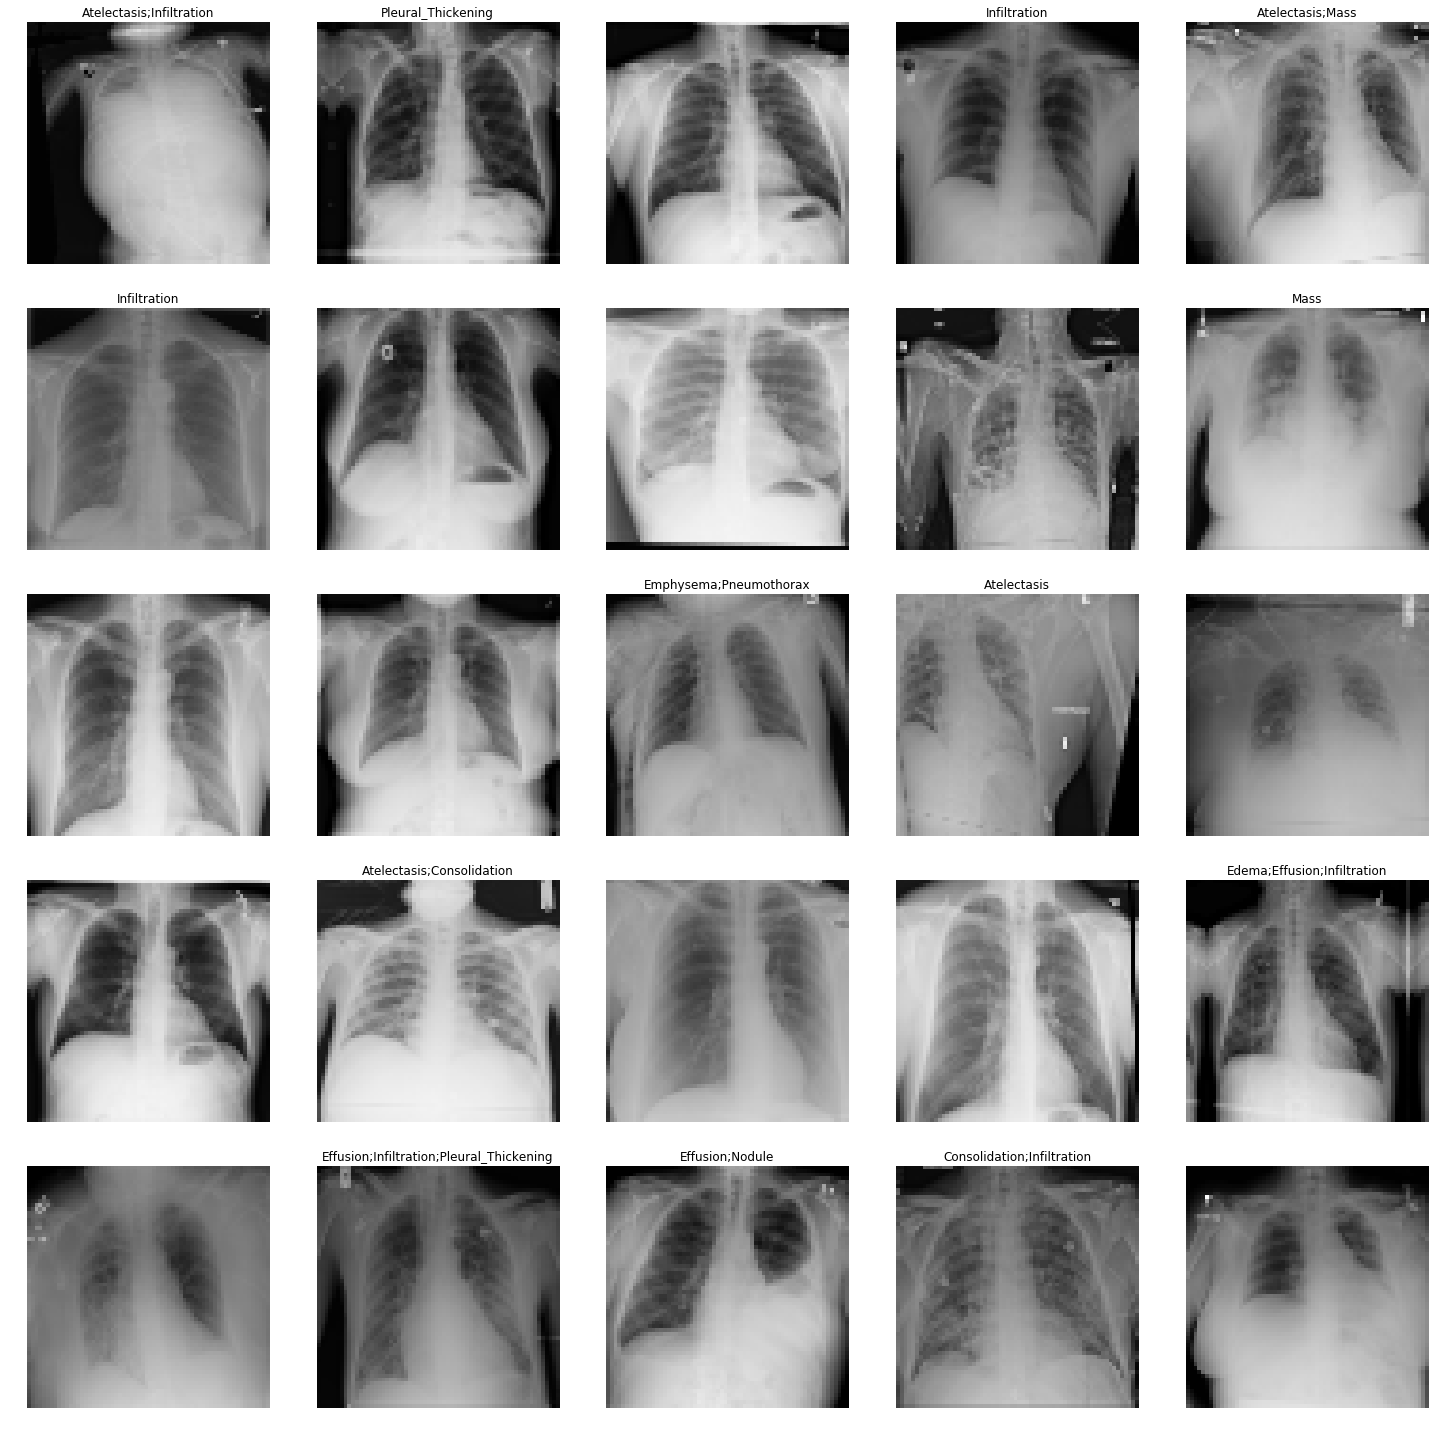

In [124]:
db_xrays.show_batch()

In [159]:
def auroc_score(input_, target):
    input_, target = input_.cpu().numpy(), target.cpu().numpy() #.reshape(-1, learn.data.c)
    score = []
    for i in range(14):
        try: 
            score.append(roc_auc_score(target[:,i], input_[:,i]))
        except ValueError:
            score.append(0)
    
    return np.array(score).mean()

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = auroc_score(output, target)
            return add_metrics(last_metrics, metric)



In [160]:
# preds = model.pred_batch(model.data.train_ds.x[:5])

In [161]:
# preds.cpu().numpy().shape

In [162]:
# from functools import partial

# accuracy_20 = partial(accuracy_thresh, thresh=0.2)

model = cnn_learner(data=db_xrays, 
                   base_arch=models.densenet121,
                   metrics=[AUROC(), ]
#                     callback_fns=AUROC
                   )

In [ ]:
model.summary()

In [163]:
model.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace)
   (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU(inplace)
   (9): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): ReLU(inplace)
   (15): Conv2d(128, 32, kernel_s

In [ ]:
model.data.c, model.data.classes

In [ ]:
model.lr_find()
model.recorder.plot()

In [164]:
model.fit_one_cycle(cyc_len=2, max_lr=7e-2)

epoch,train_loss,valid_loss,auroc,time
0,0.554224,13.295409,0.183333,00:11
1,0.459985,2.832067,0.285714,00:11


In [201]:
model.save('stage1')

In [203]:
model.load('stage1')
model.unfreeze()
model.freeze_to(0)
# model.freeze()

In [204]:
model.data = (basic_block
            .transform(tfms, 
                       size=128) 
            .databunch(bs=32))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


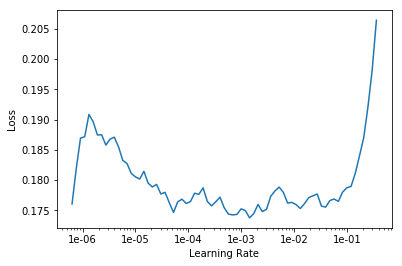

In [205]:
model.lr_find()
model.recorder.plot()

In [206]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.178613,0.174714,0.061987,0.940551,00:40
1,0.178349,0.173872,0.064776,0.937174,00:41
2,0.176079,0.173641,0.059650,0.938384,00:39
3,0.180584,0.173240,0.062761,0.938257,00:40
4,0.179638,0.173295,0.057508,0.940614,00:41
5,0.177173,0.173037,0.062464,0.938575,00:40


In [207]:
model.save('stage2')

In [211]:
# x, y = next(iter(model.data.train_dl))

LabelList (4485 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Emphysema;Infiltration;Pleural_Thickening;Pneumothorax,Cardiomegaly;Emphysema,,Atelectasis,Cardiomegaly;Edema;Effusion
Path: ../../data/kaggle/sample/images

In [191]:
# y.sum(dim=1)

tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 2., 2., 4., 2., 2., 0., 1.,
        1., 1., 2., 2., 1., 0., 2., 1., 1., 1., 0., 1., 0., 1.],
       device='cuda:0')

In [217]:
# dt = vision.open_image(path_data/'00030635_002.png')
for i in range(20):
    print('\n')
    dt = model.data.train_ds[i]
    print(dt[1])
    predict_class, predict_idx, predict_values = model.predict(dt[0])
    print(predict_values, np.array(model.data.classes)[np.array(predict_values.tolist()) > 0.1])



Emphysema;Infiltration;Pleural_Thickening;Pneumothorax
tensor([0.1078, 0.0414, 0.0825, 0.0387, 0.2102, 0.0300, 0.0126, 0.0019, 0.2325,
        0.1022, 0.0943, 0.0620, 0.0195, 0.1119]) ['Atelectasis' 'Effusion' 'Infiltration' 'Mass' 'Pneumothorax']


Cardiomegaly;Emphysema
tensor([0.0794, 0.0157, 0.0171, 0.0066, 0.0474, 0.0156, 0.0100, 0.0009, 0.1362,
        0.0346, 0.0535, 0.0164, 0.0041, 0.0239]) ['Infiltration']



tensor([0.1252, 0.0283, 0.0401, 0.0179, 0.0867, 0.0109, 0.0056, 0.0010, 0.1638,
        0.0401, 0.0490, 0.0142, 0.0067, 0.0322]) ['Atelectasis' 'Infiltration']


Atelectasis
tensor([0.0679, 0.0195, 0.0263, 0.0064, 0.0868, 0.0256, 0.0304, 0.0023, 0.1110,
        0.0863, 0.0595, 0.0393, 0.0068, 0.0776]) ['Infiltration']


Cardiomegaly;Edema;Effusion
tensor([0.1537, 0.0365, 0.0796, 0.0440, 0.1545, 0.0149, 0.0049, 0.0013, 0.2316,
        0.0570, 0.0542, 0.0207, 0.0133, 0.0464]) ['Atelectasis' 'Effusion' 'Infiltration']


Consolidation;Mass
tensor([0.0619, 0.0117, 0.0086, 0.

In [144]:
preds,y,losses = model.get_preds(with_loss=True)

In [109]:
preds = preds.float()
y = y.float()
losses = losses.float()

In [146]:
# interp = ClassificationInterpretation(model, preds, y, losses)
# interp.most_confused()

tensor([0.1666, 0.0476, 0.0914, 0.0365, 0.2287, 0.0535, 0.0245, 0.0028, 0.3991,
        0.1073, 0.1171, 0.0640, 0.0156, 0.1249])


MultiCategory 